# 환경 설정

In [7]:
import pkg_resources
import subprocess
import sys

def install_if_missing(package_name, pip_name=None):
    """패키지가 없으면 설치하고, 있으면 스킵. 출력도 숨김."""
    if pip_name is None:
        pip_name = package_name

    try:
        pkg_resources.get_distribution(package_name)
    except pkg_resources.DistributionNotFound:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pip_name],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )

# -------------------------
# 필요한 패키지 설치 (있으면 스킵)
# -------------------------

install_if_missing("pdfminer.six")
install_if_missing("pandas")
install_if_missing("pymupdf", "pymupdf")  # ← 수정됨
install_if_missing("transformers")
install_if_missing("accelerate")
install_if_missing("scikit-learn")
install_if_missing("tqdm")


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    RobertaForMultipleChoice,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
config = {
    "model_name": "roberta-base",  # or roberta-large
    "max_len": 128,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "epochs": 8,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "max_grad_norm": 1.0,
}

config

{'model_name': 'roberta-base',
 'max_len': 128,
 'batch_size': 16,
 'learning_rate': 2e-05,
 'epochs': 8,
 'weight_decay': 0.01,
 'warmup_ratio': 0.1,
 'max_grad_norm': 1.0}

In [11]:
# ===== 전역 테마 & 한글 폰트 설정 =====
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
import os

# 밝은(화이트) 배경 유지 + 파란계열 포커스
plt.style.use('default')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['savefig.facecolor'] = 'white'

# 🔤 한글 폰트 설정
font_path = '/content/NanumGothic.ttf'
if os.path.exists(font_path):
    fontprop = fm.FontProperties(fname=font_path)
    rcParams['font.family'] = fontprop.get_name()
else:
    print(f"⚠️ 폰트 파일을 찾을 수 없습니다: {font_path}  (영문 폰트로 대체)")

# 마이너스 기호 깨짐 방지
rcParams['axes.unicode_minus'] = False

print("✅ 전역 테마 & 한글 폰트 설정 완료")

⚠️ 폰트 파일을 찾을 수 없습니다: /content/NanumGothic.ttf  (영문 폰트로 대체)
✅ 전역 테마 & 한글 폰트 설정 완료


✅ 한글 폰트 설정 완료: NanumGothic


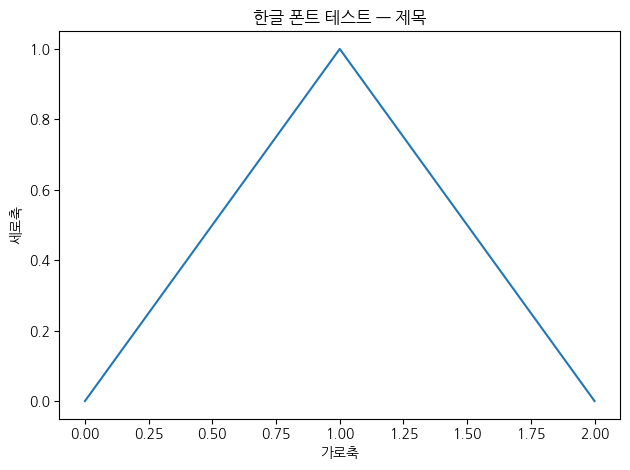

In [39]:
# ===== 한글 폰트 자동 설정 + 밝은 파랑 테마 =====
import os
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

# 1) 밝은 테마(화이트 배경) 고정
plt.style.use('default')
rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor']   = 'white'
rcParams['savefig.facecolor']= 'white'
rcParams['axes.unicode_minus'] = False  # 한글 폰트와 마이너스 기호 깨짐 방지

# 2) 한글 폰트 후보 목록
KOREAN_FONT_CANDIDATES = [
    'NanumGothic',          # 리눅스/윈도우/직접설치
    'Noto Sans CJK KR',     # 리눅스/맥
    'Noto Sans KR',         # 일반 Noto Sans KR
    'Apple SD Gothic Neo',  # macOS
    'Malgun Gothic',        # Windows
    'NanumGothicCoding'
]

def pick_available_korean_font():
    # 시스템에 등록된 폰트 이름 수집
    installed = {f.name for f in fm.fontManager.ttflist}
    for name in KOREAN_FONT_CANDIDATES:
        if name in installed:
            return name
    return None

def ensure_local_font(ttf_path):
    """작업 폴더에 TTF가 있을 때 런타임에 등록"""
    if os.path.exists(ttf_path):
        try:
            fm.fontManager.addfont(ttf_path)
            # 캐시 갱신
            try:
                fm._load_fontmanager(try_read_cache=False)
            except Exception:
                pass
            return True
        except Exception as e:
            print(f"⚠️ 폰트 등록 실패: {e}")
    return False

# 3) 우선 시스템 폰트에서 찾기
font_name = pick_available_korean_font()

# 4) 시스템에 없으면 로컬 ttf 등록 시도 (경로를 본인 환경에 맞게 바꾸세요)
LOCAL_TTF = '/content/NanumGothic.ttf'
if font_name is None and ensure_local_font(LOCAL_TTF):
    font_name = pick_available_korean_font()

# 5) 최종 설정
if font_name:
    rcParams['font.family'] = font_name
    print(f"✅ 한글 폰트 설정 완료: {font_name}")
else:
    print("⚠️ 사용 가능한 한글 폰트를 찾지 못했습니다. 영문 기본 폰트로 진행합니다.")
    print("   해결법: 시스템에 NanumGothic/Noto Sans CJK KR 등을 설치하거나,")
    print("   현재 폴더에 'NanumGothic.ttf'를 넣은 뒤 LOCAL_TTF 경로를 맞춰주세요.")

# 6) 테스트 플롯
plt.figure()
plt.title("한글 폰트 테스트 — 제목")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([0,1,2],[0,1,0])
plt.tight_layout()
plt.show()


#데이터 전처리

## 문제 데이터 전처리

In [13]:
import fitz # PyMuPDF

def extract_text_with_pymupdf(pdf_path):
    """
    PyMuPDF를 사용하여 PDF 파일에서 텍스트를 추출합니다.
    """
    text = ""
    try:
        doc = fitz.open(pdf_path)
        for page_num in range(doc.page_count):
            page = doc.load_page(page_num)
            text += page.get_text()
        doc.close()
    except Exception as e:
        print(f"PDF 텍스트 추출 중 오류 발생: {e}")
    return text

print("✅ PyMuPDF 텍스트 추출 함수 정의 완료")

✅ PyMuPDF 텍스트 추출 함수 정의 완료


In [14]:
# 문제 PDF 원시 텍스트 출력
PROBLEM_PDF = '/content/toeic_part5_2196.pdf' # 문제 파일 경로 추가

raw_problem_content = extract_text_with_pymupdf(PROBLEM_PDF)
print("--- 문제 PDF 원시 텍스트 시작 ---")
print(raw_problem_content[:5000])

with open("part5_2196.txt", "w", encoding="utf-8") as f:
    f.write(raw_problem_content)


--- 문제 PDF 원시 텍스트 시작 ---
 
 
TOEIC PART 5  
2196 Problems  
 
Compiled by krystal 
 
 
 
 
 
 
 
 
Copyright (C) 2014 hackers all rights reserved. 
[문제1] 
1.To _______ the repair job on time, the engineer 
asked the carpenters and electricians to do 
overtime yesterday.  
(A) finished 
(B) finishing 
(C) finishes 
(D) finish 
[문제2] 
2.The union leader plans to _______ his remarks 
on work safety problems to the management 
during the meeting this afternoon.  
(A) address 
(B) exalt 
(C) broadcast 
(D) send 
[문제3] 
3._______ to secure your export products, we 
recommend that you have them insured before 
shipment.  
(A) In order 
(B) So that 
(C) Though 
(D) Because  
[문제4] 
1.The consultant was impressed that the 
draftsmen worked efficiently even without the -
------- of a design director.  
(A) standard 
(B) correction 
(C) supervision 
(D) accuracy 
[문제5] 
2.Jerry Cunningham will ------- the names of 
researchers and production assistants who will 
join Ms. Marina Fletcher at the Pa

In [15]:
# 정답 PDF 원시 텍스트 출력
ANSWER_PDF = '/content/toeic_part5_2196_answer.pdf' # 정답 파일 경로 추가

raw_answer_content = extract_text_with_pymupdf(ANSWER_PDF)
print("--- 정답 PDF 원시 텍스트 시작 ---")
print(raw_answer_content[:5000])

with open("part5_2196_answer.txt", "w", encoding="utf-8") as f:
    f.write(raw_answer_content)

--- 정답 PDF 원시 텍스트 시작 ---
 
 
TOEIC PART 5  
2196 Problems 
Answer Keys 
 
Compiled by krystal 
 
 
 
 
 
 
Copyright (C) 2014 hackers all rights reserved. 
[문제1] 
[해석]  
정시에 보수 작업을 마치기 위해, 엔지니어는 
어제 목공들과 전기 기사들에게 초과근무를 할 
것을 부탁했다.  
[해설]  
to 부정사의 동사원형 채우기 문제  
‘To _______ the repair job on time’은 to 부정사
구로 빈칸에는 동사원형이 와야 하며, ‘정시에 
보수 작업을 마치기 위해’로 해석된다. 따라서 
정답은 (D) finish이다.  
[어휘]  
carpenter 목공, 목수 electrician 전기 기사 do 
overtime 초과근무 하다  
[정답]  
(D) 
[문제2] 
[해석]  
노동조합 간부는 오늘 오후 회의에서 경영진들
에게 노동 안전 문제들에 관한 그의 의견을 이
야기 할 계획이다.  
[해설]  
동사 어휘 문제  
‘간부는 회의에서 노동 안전 문제들에 관한 그
의 의견을 이야기할 계획이다’라는 문맥상 ‘이
야기하다, 말하다’라는 의미가 되어야 자연스러
우므로 빈칸에 적절한 동사는 (A) address(이야
기하다, 말하다)이다. (B) exalt는 ‘높이다, 자극
하다’, (C) broadcast는 ‘방송하다’, (D) send는 ‘보
내다’의 의미이다.  
[어휘]  
union 노동조합 remark 의견, 말 management 
경영진  
[정답]  
(A) 
[문제3] 
[해석]  
귀하의 수출 제품들을 안전하게 하기 위해, 저
희는 선적 전에 제품들을 보험에 들어놓을 것
을 제안합니다.  
[해설]  
in order to 채우기 문제  
to와 어울려 쓰일 수 있는 것은 (A) In order로 
‘in order to’는 ‘~하기 위해’라는 의미이다.  
[어휘]  
secure 안전하게

In [16]:
import re
import pandas as pd

def read_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

def parse_txt_by_block_final(raw_text):
    """
    [문제2187] 3.문장 ... (A) .. (B) .. (C) .. (D) ..
    형태의 문제를 정확히 추출하는 정규식 버전
    """

    # 줄바꿈 → 공백, 중복 공백 제거
    cleaned = re.sub(r'\s+', ' ', raw_text).strip()

    # 패턴 정의
    pattern = re.compile(
        r'\[문제(\d+)\]\s*'                 # [문제2187]
        r'(\d+)\.\s*(.*?)\s*'              # 3. Some of the employees...
        r'\(A\)\s*(.*?)\s*'                # (A) text
        r'\(B\)\s*(.*?)\s*'                # (B) text
        r'\(C\)\s*(.*?)\s*'                # (C) text
        r'\(D\)\s*(.*?)\s*'                # (D) text
        r'(?=\[문제\d+\]|\Z)',             # 다음 문제 또는 끝
        re.DOTALL
    )

    data = []
    for m in pattern.finditer(cleaned):
        data.append({
            "Question_ID": int(m.group(1)),
            "Question_Text": m.group(3).strip(),
            "Option_A": m.group(4).strip(),
            "Option_B": m.group(5).strip(),
            "Option_C": m.group(6).strip(),
            "Option_D": m.group(7).strip(),
        })

    return pd.DataFrame(data)


# 실행
raw_text = read_txt_file('/content/part5_2196.txt')
problems_df = parse_txt_by_block_final(raw_text)

print(f"✅ 추출 성공: 총 {len(problems_df)}개의 문제 추출 완료.")
print("\n--- 문제 데이터프레임 미리보기 ---")
print(problems_df[['Question_ID', 'Question_Text', 'Option_A', 'Option_B', 'Option_C', 'Option_D']].head())

problems_df.to_csv('toeic_problem_dataset.csv', index=False, encoding='utf-8-sig')


✅ 추출 성공: 총 2196개의 문제 추출 완료.

--- 문제 데이터프레임 미리보기 ---
   Question_ID                                      Question_Text  Option_A  \
0            1  To _______ the repair job on time, the enginee...  finished   
1            2  The union leader plans to _______ his remarks ...   address   
2            3  _______ to secure your export products, we rec...  In order   
3            4  The consultant was impressed that the draftsme...  standard   
4            5  Jerry Cunningham will ------- the names of res...  announce   

     Option_B     Option_C  Option_D  
0   finishing     finishes    finish  
1       exalt    broadcast      send  
2     So that       Though   Because  
3  correction  supervision  accuracy  
4     diffuse        trade   command  


## 정답 데이터 전처리

In [17]:
import re
import pandas as pd
import os

def read_txt_file(file_path):
    encodings = ['utf-8', 'euc-kr', 'latin-1']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.read()
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(f"오류: {file_path}를 모든 인코딩으로 디코딩할 수 없습니다.")


def split_problem_blocks(text):
    blocks = re.split(r'(?=\[문제\s*\d+\s*\])', text)
    return [b.strip() for b in blocks if b.strip()]


def parse_answer_from_block(block):
    qid_match = re.search(r'\[문제\s*(\d+)\s*\]', block)
    if not qid_match:
        return None

    qid = int(qid_match.group(1))

    ans_match = re.search(r'\[정답\]\s*\n\s*\(\s*([A-D])\s*\)', block)
    if not ans_match:
        return None

    answer = ans_match.group(1)
    return qid, answer


def parse_clean_answer_key(raw_answer_text):
    text = re.sub(r'\r\n?', '\n', raw_answer_text)
    blocks = split_problem_blocks(text)

    qids = []
    answers = []

    for block in blocks:
        result = parse_answer_from_block(block)
        if result:
            qid, answer = result
            qids.append(qid)
            answers.append(answer)

    return pd.DataFrame({
        "Question_ID": qids,
        "Answer_Label": answers
    })


# -------- 실행 ---------

answer_file_path = '/content/part5_2196_answer.txt'

try:
    if not os.path.exists(answer_file_path):
        print(f"🚨 정답 파일 '{answer_file_path}'이 없습니다.")
    else:
        raw_text = read_txt_file(answer_file_path)
        answers_df = parse_clean_answer_key(raw_text)

        answers_df['Target_Class'] = answers_df['Answer_Label'].map({'A':0,'B':1,'C':2,'D':3})

        print(f"✅ 정답 {len(answers_df)}개 추출 완료")
        print(answers_df.head())

        answers_df.to_csv('toeic_answer_dataset.csv', index=False, encoding='utf-8-sig')
        print("CSV 저장 완료!")

except Exception as e:
    print("🚨 오류:", e)


✅ 정답 2196개 추출 완료
   Question_ID Answer_Label  Target_Class
0            1            D             3
1            2            A             0
2            3            A             0
3            4            C             2
4            5            A             0
CSV 저장 완료!


## 문제-정답 매칭

In [18]:
import pandas as pd

problems = pd.read_csv("/content/toeic_problem_dataset.csv")
answers  = pd.read_csv("/content/toeic_answer_dataset.csv")

final_dataset_df = problems.merge(answers, on="Question_ID", how="inner") # Variable name changed from 'final' to 'final_dataset_df'

print("최종 병합 개수:", len(final_dataset_df))
final_dataset_df.to_csv("/content/toeic_final_dataset_merged.csv", index=False, encoding="utf-8-sig")

print("병합 완료!")
print("\n--- 최종 학습 데이터셋 미리보기 ---")
print(final_dataset_df[['Question_ID', 'Question_Text', 'Option_A', 'Answer_Label', 'Target_Class']].head())

# Redundant assignment removed
print("\n✅ 최종 CSV 파일 'toeic_final_dataset_merged.csv' 저장 완료. 이제 PyTorch 학습을 시작할 수 있습니다. 🚀")

최종 병합 개수: 2196
병합 완료!

--- 최종 학습 데이터셋 미리보기 ---
   Question_ID                                      Question_Text  Option_A  \
0            1  To _______ the repair job on time, the enginee...  finished   
1            2  The union leader plans to _______ his remarks ...   address   
2            3  _______ to secure your export products, we rec...  In order   
3            4  The consultant was impressed that the draftsme...  standard   
4            5  Jerry Cunningham will ------- the names of res...  announce   

  Answer_Label  Target_Class  
0            D             3  
1            A             0  
2            A             0  
3            C             2  
4            A             0  

✅ 최종 CSV 파일 'toeic_final_dataset_merged.csv' 저장 완료. 이제 PyTorch 학습을 시작할 수 있습니다. 🚀


# 문제 학습

## 데이터 로드

In [19]:
final_dataset_df = pd.read_csv("toeic_final_dataset_merged.csv")
final_dataset_df.head()

print("--- 'toeic_final_dataset_merged.csv' 파일 로드 완료 ---")
print(final_dataset_df.head())

--- 'toeic_final_dataset_merged.csv' 파일 로드 완료 ---
   Question_ID                                      Question_Text  Option_A  \
0            1  To _______ the repair job on time, the enginee...  finished   
1            2  The union leader plans to _______ his remarks ...   address   
2            3  _______ to secure your export products, we rec...  In order   
3            4  The consultant was impressed that the draftsme...  standard   
4            5  Jerry Cunningham will ------- the names of res...  announce   

     Option_B     Option_C  Option_D Answer_Label  Target_Class  
0   finishing     finishes    finish            D             3  
1       exalt    broadcast      send            A             0  
2     So that       Though   Because            A             0  
3  correction  supervision  accuracy            C             2  
4     diffuse        trade   command            A             0  


In [20]:
# NaN 처리 + 텍스트 컬럼 보정
text_columns = ["Question_Text", "Option_A", "Option_B", "Option_C", "Option_D"]
final_dataset_df[text_columns] = final_dataset_df[text_columns].fillna("").astype(str)


In [21]:
# Tokenizer 준비
tokenizer = AutoTokenizer.from_pretrained(config["model_name"])

def encode_item(question, options):
    """
    question: string
    options: [A, B, C, D]
    return: input_ids(4,max_len), attention_mask(4,max_len)
    """
    encoded = tokenizer(
        [question] * 4,
        options,
        padding="max_length",
        truncation=True,
        max_length=config["max_len"],
        return_tensors="pt"
    )
    return encoded["input_ids"], encoded["attention_mask"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
# 전체 데이터 토크나이징
input_ids_list = []
attention_mask_list = []
labels_list = []

for _, row in final_dataset_df.iterrows():
    question = row["Question_Text"]
    options = [
        row["Option_A"],
        row["Option_B"],
        row["Option_C"],
        row["Option_D"]
    ]
    label = row["Target_Class"]  # 0~3 integer

    ids, mask = encode_item(question, options)

    input_ids_list.append(ids)
    attention_mask_list.append(mask)
    labels_list.append(label)

print("토크나이징 완료!")


토크나이징 완료!


## Dataset & DataLoader

In [23]:
# Dataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],          # shape: (4, max_len)
            "attention_mask": self.attention_mask[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [36]:
# Combine all processed data into a temporary DataFrame for easier splitting
temp_df = pd.DataFrame({
    'input_ids': input_ids_list,
    'attention_mask': attention_mask_list,
    'labels': labels_list,
    'Question_Text': final_dataset_df['Question_Text'].tolist(),
    'options': final_dataset_df['options'].tolist() # Ensure 'options' column is available
})

# Train/Validation split on the temporary DataFrame
train_df, val_df = train_test_split(
    temp_df,
    test_size=0.2,
    random_state=42,
    stratify=temp_df['labels'] # Stratify by labels to maintain class distribution
)

# Reset index for clean access
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Now create CustomDataset instances using the split DataFrames
train_dataset = CustomDataset(
    input_ids=train_df['input_ids'].tolist(),
    attention_mask=train_df['attention_mask'].tolist(),
    labels=train_df['labels'].tolist()
)

val_dataset = CustomDataset(
    input_ids=val_df['input_ids'].tolist(),
    attention_mask=val_df['attention_mask'].tolist(),
    labels=val_df['labels'].tolist()
)

train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

# Update val_labels for plotting from the val_df
# val_labels will be used in the plotting cell hUuqeB_9clbK
val_labels = np.array(val_df['labels'].tolist())

print("✔ Train/Val DataLoader 및 DataFrame 생성 완료")

✔ Train/Val DataLoader 및 DataFrame 생성 완료


## 모델 생성 + Optimizer + Schduler

In [26]:
from torch.optim import AdamW # AdamW 임포트 추가

model = RobertaForMultipleChoice.from_pretrained(config["model_name"]).to(device)

optimizer = AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"]
)

total_steps = len(train_dataloader) * config["epochs"]
warmup_steps = int(total_steps * config["warmup_ratio"])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    warmup_steps,
    total_steps
)

print("✔ Model + Optimizer + Scheduler 준비 완료")

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✔ Model + Optimizer + Scheduler 준비 완료


## Training Loop

In [27]:
for epoch in range(config["epochs"]):
    print(f"\n======== Epoch {epoch + 1} / {config['epochs']} ========")

    # ---------------- TRAIN -----------------
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    print(f"Training Loss: {total_loss/len(train_dataloader):.4f}, Acc: {train_acc:.4f}")


    # ---------------- VALIDATION -----------------
    model.eval()
    val_loss = 0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            val_correct += (preds == labels).sum().item()
            val_samples += labels.size(0)

    val_acc = val_correct / val_samples
    print(f"Validation Loss: {val_loss/len(val_dataloader):.4f}, Acc: {val_acc:.4f}")

print("\n=== Training Complete ===")



======== Epoch 1 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 1.3848, Acc: 0.2694


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 1.3799, Acc: 0.3705

======== Epoch 2 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 1.2063, Acc: 0.4601


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 0.8792, Acc: 0.6773

======== Epoch 3 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 0.7199, Acc: 0.7278


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 0.5945, Acc: 0.8000

======== Epoch 4 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 0.3927, Acc: 0.8548


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 0.4720, Acc: 0.8318

======== Epoch 5 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 0.2595, Acc: 0.9117


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 0.5184, Acc: 0.8477

======== Epoch 6 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 0.1712, Acc: 0.9396


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 0.5060, Acc: 0.8523

======== Epoch 7 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 0.1243, Acc: 0.9550


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 0.4741, Acc: 0.8614

======== Epoch 8 / 8 ========


Training:   0%|          | 0/110 [00:00<?, ?it/s]

Training Loss: 0.0978, Acc: 0.9727


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Validation Loss: 0.4762, Acc: 0.8659

=== Training Complete ===


## 모델 저장

In [43]:
model.save_pretrained("toeic_roberta_mcq_model")
tokenizer.save_pretrained("toeic_roberta_mcq_model")
print("✔ 모델 저장 완료")

✔ 모델 저장 완료


# 모델 평가

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

# 🔥 평가 함수 정의
def evaluate_model(model, dataloader, device):
    model.eval()
    preds = []
    labels_list = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)         # (B, 4, L)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 모델에 input_ids와 attention_mask를 직접 전달 (flattening 없이)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits  # 예상되는 shape: (batch_size, num_options)

            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return np.array(preds), np.array(labels_list)

# 🔥 검증 데이터셋 성능 측정
val_preds, val_labels = evaluate_model(model, val_dataloader, device)

print("📌 Validation Classification Report")
print(classification_report(val_labels, val_preds))

print("📌 Confusion Matrix")
print(confusion_matrix(val_labels, val_preds))


📌 Validation Classification Report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       109
           1       0.87      0.86      0.86       115
           2       0.87      0.90      0.89       115
           3       0.91      0.83      0.87       101

    accuracy                           0.87       440
   macro avg       0.87      0.86      0.87       440
weighted avg       0.87      0.87      0.87       440

📌 Confusion Matrix
[[ 94   8   3   4]
 [  7  99   8   1]
 [  6   2 104   3]
 [  8   5   4  84]]


## 새로운 문제 예측

In [32]:
def predict_answer(question, options):
    model.eval()

    inputs = tokenizer(
        [question] * len(options),
        options,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=256
    )

    # GPU/CPU로 이동
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits.view(1, len(options), -1)
        logits = logits.mean(dim=1)

    pred = torch.argmax(logits, dim=1).item()
    return pred

# 사용 예시
# predict_answer("What does the speaker suggest?", ["Option A", "Option B", "Option C", "Option D"])


## 오답 분석

In [34]:
import numpy as np
import pandas as pd

# 'options' 컬럼 추가 (리스트 형태로 묶음)
final_dataset_df['options'] = final_dataset_df.apply(
    lambda row: [row['Option_A'], row['Option_B'], row['Option_C'], row['Option_D']],
    axis=1
)

# pred와 label은 이미 평가에서 얻은 val_preds, val_labels 값
wrong_idx = np.where(val_preds != val_labels)[0]
print(f"❌ 오답 개수: {len(wrong_idx)}")

# 오답 데이터프레임
error_df = final_dataset_df.iloc[wrong_idx].copy()
error_df["pred"] = val_preds[wrong_idx]
error_df["label"] = val_labels[wrong_idx]

# 오답 옵션 텍스트 추출 함수
def pred_option(row):
    return row["options"][row["pred"]]

def correct_option(row):
    return row["options"][row["label"]]

error_df["pred_text"] = error_df.apply(pred_option, axis=1)
error_df["correct_text"] = error_df.apply(correct_option, axis=1)

print("📌 오답 예시 5개:")
display(error_df.iloc[:5])

❌ 오답 개수: 59
📌 오답 예시 5개:


,Question_ID,Question_Text,Option_A,Option_B,Option_C,Option_D,Answer_Label,Target_Class,options,pred,label,pred_text,correct_text
5,6,"With all the negative reviews about the novel,...",misinterpret,misinterprets,misinterpreting,misinterpreted,D,3,"[misinterpret, misinterprets, misinterpreting,...",1,2,misinterprets,misinterpreting
12,13,The national economy has been ------- for near...,stagnant,stagnancy,stagnating,stagnantly,A,0,"[stagnant, stagnancy, stagnating, stagnantly]",2,3,stagnating,stagnantly
15,16,Mr. Forester is confident that _______ can con...,you,yours,yourself,your,A,0,"[you, yours, yourself, your]",0,3,you,your
24,25,Pedestrians are advised to be _______ and look...,cautionary,cautioning,cautious,cautions,C,2,"[cautionary, cautioning, cautious, cautions]",2,1,cautious,cautioning
30,31,Automobile factories in areas _______ affected...,severity,severely,severest,severer,B,1,"[severity, severely, severest, severer]",2,1,severest,severely


## 정·오답 문제 시각화 리포트 구성

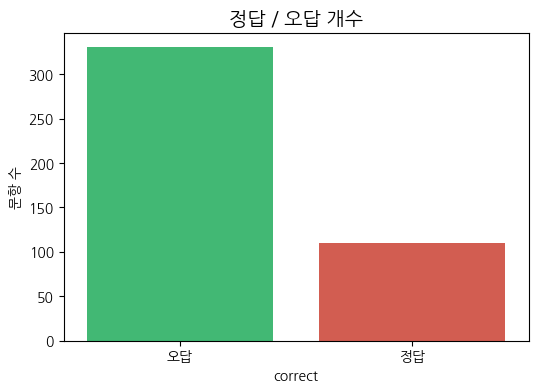

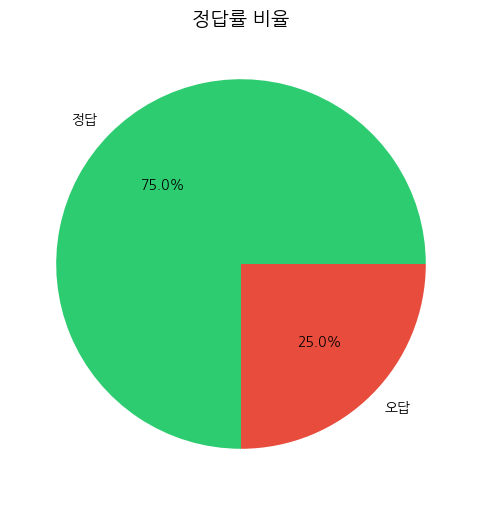

/tmp/ipython-input-2843179613.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"옵션 {i}" for i in range(num_classes)],


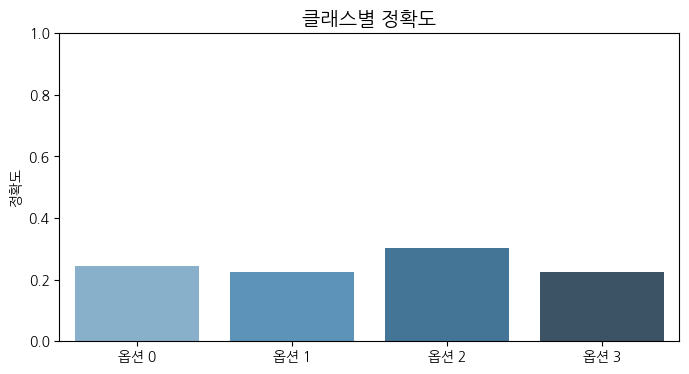

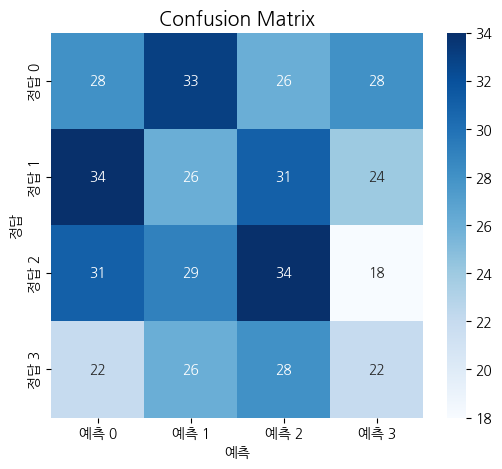

❌ 오답 문제 상세 목록 (상위 5개)


,question,option_text,label,label_text,pred,pred_text
0,"Garbage, ------- biodegradable or non- biodegr...",A: whenever\nB: until\nC: also\nD: whether,3,whether,1,until
2,The director left instructions that if _______...,A: Them\nB: Whomever\nC: Anyone\nD: Itself,2,Anyone,1,Whomever
3,An official at the television station said tha...,A: over\nB: within\nC: among\nD: besides,0,over,2,among
4,Davy Nesmith brought _______ computer to the s...,A: his\nB: he\nC: himself\nD: him,0,his,1,he
5,Ken Yoshida has been assigned to write a summa...,A: that\nB: what\nC: these\nD: when,0,that,1,what


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# val_preds, val_labels는 검증 평가에서 나온 변수
report_df = pd.DataFrame({
    "question": val_df["Question_Text"].tolist(), # Use val_df
    "options": val_df["options"].tolist(),       # Use val_df
    "label": val_labels,
    "pred": val_preds
})

report_df["correct"] = (report_df["label"] == report_df["pred"])

correct_counts = report_df["correct"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(
    x=correct_counts.index.map({True:"정답", False:"오답"}),
    y=correct_counts.values,
    hue=correct_counts.index.map({True:"정답", False:"오답"}),
    palette=["#2ecc71", "#e74c3c"],
    dodge=False,
    legend=False
)

plt.title("정답 / 오답 개수", fontsize=14)
plt.ylabel("문항 수")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(correct_counts.values,
        labels=["정답", "오답"],
        autopct="%.1f%%",
        colors=["#2ecc71", "#e74c3c"])
plt.title("정답률 비율", fontsize=14)
plt.show()

class_acc = []
num_classes = 4

for c in range(num_classes):
    idx = np.where(val_labels == c)[0]
    acc = (val_preds[idx] == val_labels[idx]).mean()
    class_acc.append(acc)

plt.figure(figsize=(8,4))
sns.barplot(x=[f"옵션 {i}" for i in range(num_classes)],
            y=class_acc,
            palette="Blues_d")
plt.title("클래스별 정확도", fontsize=14)
plt.ylabel("정확도")
plt.ylim(0, 1)
plt.show()

cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"예측 {i}" for i in range(num_classes)],
            yticklabels=[f"정답 {i}" for i in range(num_classes)])
plt.title("Confusion Matrix", fontsize=14)
plt.ylabel("정답")
plt.xlabel("예측")
plt.show()

wrong_df = report_df[report_df["correct"] == False].copy()

def option_list_to_text(row):
    opts = row["options"]
    return f"A: {opts[0]}\nB: {opts[1]}\nC: {opts[2]}\nD: {opts[3]}"

wrong_df["option_text"] = wrong_df.apply(option_list_to_text, axis=1)
wrong_df["label_text"] = wrong_df.apply(lambda row: row["options"][row["label"]], axis=1)
wrong_df["pred_text"] = wrong_df.apply(lambda row: row["options"][row["pred"]], axis=1)

print("❌ 오답 문제 상세 목록 (상위 5개)")
display(wrong_df[["question", "option_text", "label", "label_text", "pred", "pred_text"]].head(5))